In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
!pip install -r requirements.txt

In [21]:
!pip freeze > ./requirements.txt

In [4]:
import warnings
warnings.filterwarnings('ignore')

### Dependencies

In [5]:
import sagemaker
import boto3
from pyathena import connect
import pandas as pd
from botocore.config import Config

### Create S3 Bucket

In [6]:
session = sagemaker.Session()

bucket = session.default_bucket()
role = sagemaker.get_execution_role()   
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

In [7]:
bucket

'sagemaker-us-east-1-512195023911'

In [8]:
setup_s3_bucket_passed = False

In [9]:
s3 = boto3.Session().client(service_name="s3", region_name=region)

try:
    if ~setup_s3_bucket_passed:
        response = s3.head_bucket(Bucket=bucket)
    print(f"response : {response}")
    setup_s3_bucket_passed = True
except Exception as e:
    print(e)


response : {'ResponseMetadata': {'RequestId': '8Y0W0YWD8CESX593', 'HostId': 'uUIfOYBDMIcjxx4p1JlKKEA0p8m3Tt4yA5DoaGM7XDFlCGsTzxKVeoeqoTIhZ4wawjVA+q2xLno=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'uUIfOYBDMIcjxx4p1JlKKEA0p8m3Tt4yA5DoaGM7XDFlCGsTzxKVeoeqoTIhZ4wawjVA+q2xLno=', 'x-amz-request-id': '8Y0W0YWD8CESX593', 'date': 'Sun, 29 Sep 2024 14:11:44 GMT', 'x-amz-bucket-region': 'us-east-1', 'x-amz-access-point-alias': 'false', 'content-type': 'application/xml', 'server': 'AmazonS3'}, 'RetryAttempts': 0}, 'BucketRegion': 'us-east-1', 'AccessPointAlias': False}


In [10]:
%store setup_s3_bucket_passed

Stored 'setup_s3_bucket_passed' (bool)


In [11]:
%store

Stored variables and their in-db values:
setup_s3_bucket_passed             -> True


In [12]:
bucket

'sagemaker-us-east-1-512195023911'

In [13]:
role_name = role.split("/")[-1]
role_name

'AmazonSageMaker-ExecutionRole-20240927T104794'

### Update IAM Role

In [14]:
config = Config(retries={"max_attempts":10, "mode":"adaptive"})
iam = boto3.client("iam", config=config)

In [15]:
setup_iam_roles_passed = False

#### Check the IAM role policies

In [16]:
admin = False

post_policies = iam.list_attached_role_policies(RoleName=role_name)["AttachedPolicies"]
for post_policy in post_policies:
    if post_policy["PolicyName"] == "AdministratorAccess":
        admin = True
        setup_iam_roles_passed = True
        print("Already updated")
        break
if not admin:
    print("SageMakerExecutionRole needs the AdministratorAccess policy attached.")   

Already updated


In [17]:
post_policies

[{'PolicyName': 'AmazonSageMaker-ExecutionPolicy-20240927T104794',
  'PolicyArn': 'arn:aws:iam::512195023911:policy/service-role/AmazonSageMaker-ExecutionPolicy-20240927T104794'},
 {'PolicyName': 'AdministratorAccess',
  'PolicyArn': 'arn:aws:iam::aws:policy/AdministratorAccess'},
 {'PolicyName': 'AmazonSageMakerFullAccess',
  'PolicyArn': 'arn:aws:iam::aws:policy/AmazonSageMakerFullAccess'},
 {'PolicyName': 'AmazonSageMakerCanvasAIServicesAccess',
  'PolicyArn': 'arn:aws:iam::aws:policy/AmazonSageMakerCanvasAIServicesAccess'},
 {'PolicyName': 'AmazonSageMakerCanvasFullAccess',
  'PolicyArn': 'arn:aws:iam::aws:policy/AmazonSageMakerCanvasFullAccess'},
 {'PolicyName': 'AmazonSageMakerCanvasDataPrepFullAccess',
  'PolicyArn': 'arn:aws:iam::aws:policy/AmazonSageMakerCanvasDataPrepFullAccess'}]

### Ingest Amazon Customer Review Dataset

### Load Data

In [18]:
s3_staging_dir = f"s3://{bucket}/athena/query-cache"
database_name = "default"
table_name = "amazon_reviews_dataset_parquet_latest"

In [19]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)
conn

In [287]:
statement = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{} (
        marketplace string,
        customer_id int,
        review_id string,
        product_id string,
        product_parent int,
        product_title string,
        star_rating int,
        helpful_votes int,
        total_votes int,
        vine string,
        verified_purchase string,
        review_headline string,
        review_body string,
        review_date string,
        product_category String
    )

    ROW FORMAT SERDE
        'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
    STORED AS INPUTFORMAT
        'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
    OUTPUTFORMAT
        'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
    LOCATION
        's3://amazon-reviews-data-set/parquet/'
""".format(database_name, table_name)
pd.read_sql(statement, conn)

""


### verify table has been created

In [19]:
statement = "SHOW TABLES in {}".format(database_name)

db_tables = pd.read_sql(statement, conn)
print(db_tables)

                                tab_name
0            amazon_reviews_data_parquet
1     amazon_reviews_data_parquet_latest
2  amazon_reviews_dataset_parquet_latest
3                 amazon_reviews_parquet


In [20]:

statement = f"SELECT * FROM {database_name}.{table_name}"
DF = pd.read_sql(statement, conn)
DF.shape

(101836, 15)

In [290]:
DF.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,product_category
0,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406,CCleaner Free [Download],4,0,0,N,Y,Four Stars,So far so good,2015-08-31,Digital_Software
1,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768,ResumeMaker Professional Deluxe 18,3,0,0,N,Y,Three Stars,Needs a little more work.....,2015-08-31,Digital_Software
2,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899,Amazon Drive Desktop [PC],1,1,2,N,Y,One Star,Please cancel.,2015-08-31,Digital_Software
3,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,5,0,0,N,Y,Works as Expected!,Works as Expected!,2015-08-31,Digital_Software
4,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556,SecureAnywhere Intermet Security Complete 5 De...,4,1,2,N,Y,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...,2015-08-31,Digital_Software


### Data preprocessing

In [18]:
!pip install s3fs seaborn

  Using cached fsspec-2024.9.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.9.0-py3-none-any.whl (179 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.6.0
    Uninstalling fsspec-2023.6.0:
      Successfully uninstalled fsspec-2023.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-ai 2.20.0 requires faiss-cpu<=1.8.0, which is not installed.
datasets 2.21.0 requires fsspec[http]<=2024.6.1,>=2023.1.0, but you have fsspec 2024.9.0 which is incompatible.
jupyter-scheduler 2.7.1 requires fsspec==2023.6.0, but you have fsspec 2024.9.0 which is incompatible.


In [20]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [22]:
sb.set_style = "seaborn-whitegrid"

sb.set(
    rc={
        "font.style": "normal",
        "axes.facecolor": "white",
        "grid.color": ".8",
        "grid.linestyle": "-",
        "figure.facecolor": "white",
        "figure.titlesize": 20,
        "text.color": "black",
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.labelcolor": "black",
        "axes.grid": True,
        "axes.labelsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "font.size": 10,
    }
)

In [35]:
query = """
    SELECT 	product_category, AVG(star_rating) AS avg_star_rating 
    FROM {}.{}
    GROUP BY product_category
    ORDER BY avg_star_rating DESC
""".format(database_name, table_name)

print(query)

df = pd.read_sql(query, conn)
df.head()


    SELECT 	product_category, AVG(star_rating) AS avg_star_rating 
    FROM default.amazon_reviews_dataset_parquet_latest
    GROUP BY product_category
    ORDER BY avg_star_rating DESC



,product_category,avg_star_rating
0,Digital_Software,3.539662


## Detect data bias with Amazon Sagemaker Clarify

In [21]:
config = Config(user_agent_extra = "dsoaws/1.0")

sm = boto3.Session().client(service_name="sagemaker", region_name=region, config=config)

In [37]:
import csv

# After downloading the file locally, replace the S3 path with the local file path
df = pd.read_csv(
    "s3://amazon-reviews-data-set/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv",
    delimiter='\t', 
    quoting= csv.QUOTE_NONE,
    on_bad_lines='skip')

df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406.0,CCleaner Free [Download],Digital_Software,4.0,0.0,0.0,N,Y,Four Stars,So far so good,2015-08-31
1,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768.0,ResumeMaker Professional Deluxe 18,Digital_Software,3.0,0.0,0.0,N,Y,Three Stars,Needs a little more work.....,2015-08-31
2,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899.0,Amazon Drive Desktop [PC],Digital_Software,1.0,1.0,2.0,N,Y,One Star,Please cancel.,2015-08-31
3,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534.0,Norton Internet Security 1 User 3 Licenses,Digital_Software,5.0,0.0,0.0,N,Y,Works as Expected!,Works as Expected!,2015-08-31
4,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556.0,SecureAnywhere Intermet Security Complete 5 De...,Digital_Software,4.0,1.0,2.0,N,Y,Great antivirus. Worthless customer support,"""I've had Webroot for a few years. It expired ...",2015-08-31


In [39]:
# upload data to new dir

path = "./transformed_tsv.csv"
df.to_csv(path, index=False, header=True)

data_s3_url = session.upload_data(bucket=bucket, key_prefix="bias/transformed", path=path)
data_s3_url


's3://sagemaker-us-east-1-512195023911/bias/transformed/transformed_tsv.csv'

In [40]:
from sagemaker import clarify
clarify_result_path = "s3://amazon-reviews-data-set/clarify_results"

data_config = clarify.DataConfig(
    s3_data_input_path=data_s3_url,
    s3_output_path=clarify_result_path,
    label = "star_rating",
    headers = df.columns.to_list(),
    dataset_type="text/csv"
)
data_config

#### setup BiasConfig

In [352]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold= [5,4],
    facet_name = "product_category"
)
bias_config

### setup sagemaker clarify Processing job

In [353]:
processor = clarify.SageMakerClarifyProcessor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    sagemaker_session=session
)
processor

In [354]:
processor.run_pre_training_bias(
    data_config=data_config,
    data_bias_config=bias_config,
    methods=["CI","DPL","KL","JS","LP","TVD", "KS"],
    wait=False,
    logs=False
)

In [355]:
processor.latest_job.job_name

'Clarify-Pretraining-Bias-2024-09-29-12-29-04-016'

### Balance the dataset by Product_category and Star_rating

In [365]:
df_group_by = DF.groupby(["star_rating"])
df_balanced_data = df_group_by.apply(lambda x: x.sample(df_group_by.size().min()).reset_index(drop=True))

In [366]:
df_balanced_data

marketplace  customer_id       review_id  product_id  \
star_rating                                                             
1           0             US     53013980  R3MHAIGUGJAK17  B00M9GTEPA   
            1             US     52829208  R11P2H7SEDANAA  B00KQV8DJ8   
            2             US     17817916  R3PINFZ61302O4  B00NG7JVSQ   
            3             US     51758830   RAB9U354D54KO  B008S0IWNQ   
            4             US     26788420  R3AZ2QD7ZGBRGB  B00TJCZXPM   
...                      ...          ...             ...         ...   
5           6865          US      8244826  R36MXWLQHFS9MZ  B00H9A60O4   
            6866          US      8763307  R3MHQJAPOM5VQX  B00E7X9ZOI   
            6867          US     20631531   RX0NFX0VO0JPY  B00H9A60O4   
            6868          US     40149250   RB7YC0GHZKFWD  B002PDPIF2   
            6869          US     24214160   REUNUK8GSPY4O  B00NG7JVSQ   

                  product_parent  \
star_rating                        
1           0          521201578   
            1          528756065   
            2          811978073   
            3          710343641   
            4           83095852   
...                          ...   
5           6865       608720080   
            6866       882911874   
            6867       608720080   
            6868       869467193   
            6869       811978073   

                                                      product_title  \
star_rating                                                           
1           0                   Intuit Quicken Home & Business 2015   
            1                 Advanced SystemCare 7 FREE [Download]   
            2                   TurboTax Deluxe Fed + Efile + State   
            3                                   QuickBooks Pro 2013   
            4     Arithmemouse Addition Subtraction Free [Download]   
...                                                             ...   
5           6865               Avast Free Antivirus 2015 [Download]   
            6866                          Quicken Starter Edition 2   
            6867               Avast Free Antivirus 2015 [Download]   
            6868                  Quicken Deluxe 2010 [OLD VERSION]   
            6869                TurboTax Deluxe Fed + Efile + State   

                  star_rating  helpful_votes  total_votes vine  \
star_rating                                                      
1           0               1              4            4    N   
            1               1              1            2    N   
            2               1              2            2    N   
            3               1              3            3    N   
            4               1              2            3    N   
...                       ...            ...          ...  ...   
5           6865            5              0            0    N   
            6866            5              0            0    N   
            6867            5              0            0    N   
            6868            5              2            4    N   
            6869            5              1            7    N   

                 verified_purchase  \
star_rating                          
1           0                    Y   
            1                    Y   
            2                    N   
            3                    Y   
            4                    Y   
...                            ...   
5           6865                 N   
            6866                 Y   
            6867                 N   
            6868                 Y   
            6869                 Y   

                                                    review_headline  \
star_rating                                                           
1           0     I couldn't believe that a software wasn't evol...   
            1                                    Dangerous Software   
            2                       

<Axes: xlabel='star_rating', ylabel='count'>

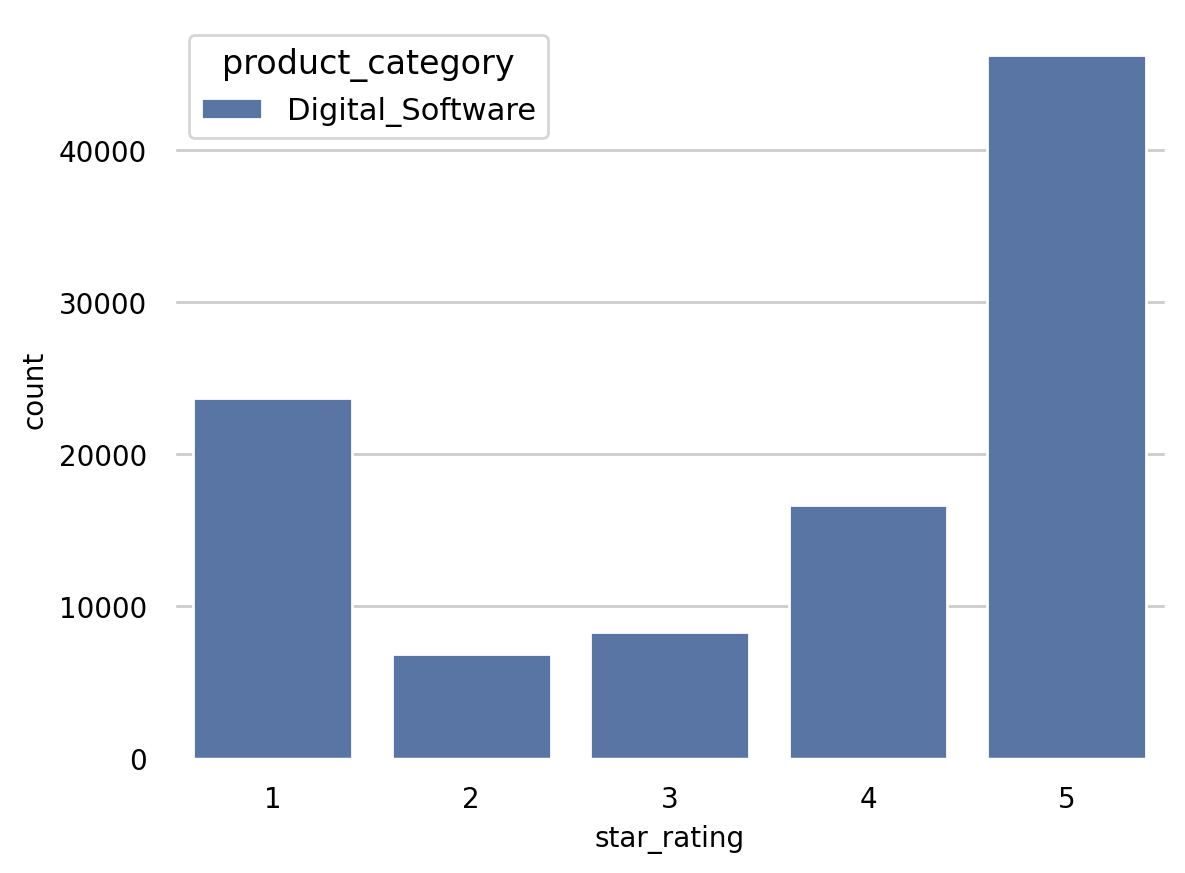

In [367]:
sb.countplot(data=DF, x="star_rating", hue= "product_category")

#### down sampling

<Axes: xlabel='star_rating', ylabel='count'>

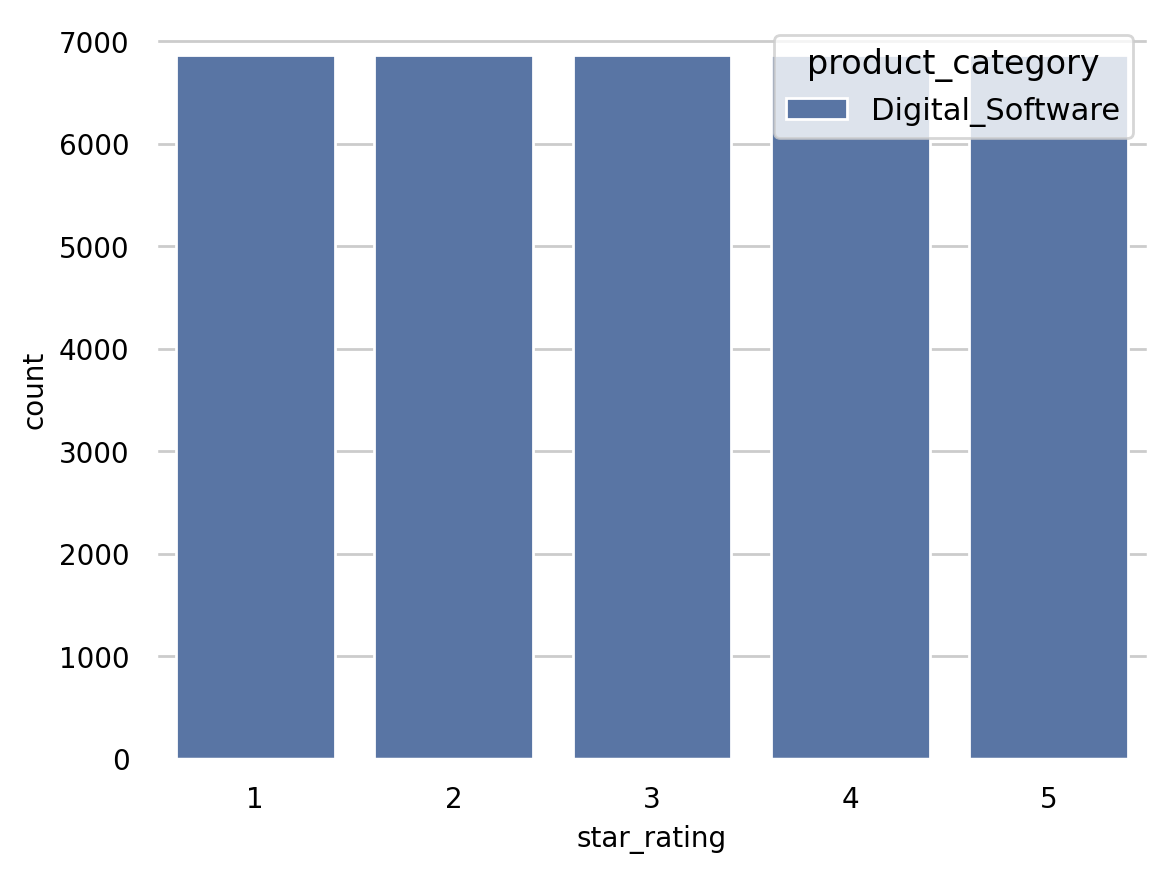

In [368]:
sb.countplot(data=df_balanced_data, x="star_rating", hue= "product_category")

## Analyze bias on balanced dataset wit clarify

In [372]:
# upload transformed data to dir

path_balanced = "./transformed_tsv_latest.csv"
df.to_csv(path_balanced, index=False, header=True)

data_s3_url_balanced = session.upload_data(bucket=bucket, key_prefix="bias/transformed", path=path_balanced)
data_s3_url_balanced

's3://sagemaker-us-east-1-512195023911/bias/transformed/transformed_tsv_latest.csv'

In [375]:
clarify_result_path_balanced = "s3://amazon-reviews-data-set/clarify_results/balanced_dataset_result"

data_config = clarify.DataConfig(
    s3_data_input_path=data_s3_url_balanced,
    s3_output_path=clarify_result_path_balanced,
    label = "star_rating",
    headers = df.columns.to_list(),
    dataset_type="text/csv"
)

bias_config = clarify.BiasConfig(
    label_values_or_threshold= [5,4],
    facet_name = "product_category"
)

processor = clarify.SageMakerClarifyProcessor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    sagemaker_session=session
)

processor.run_pre_training_bias(
    data_config=data_config,
    data_bias_config=bias_config,
    methods=["CI","DPL","KL","JS","LP","TVD", "KS"],
    wait=False,
    logs=False
)

In [ ]:
processor

### BERT Feature Engineering

In [1]:
!pip install --upgrade transformers


In [1]:
import tensorflow as tf
import collections
import json
import os


2024-09-29 14:14:28.492100: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [1]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [2]:
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

### PIPELINE

In [209]:
from botocore.exceptions import ClientError

import os
import sagemaker
import logging
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [210]:
import time

timestamp = int(time.time())

pipeline_name = "BERT-pipeline-{}".format(timestamp)

In [211]:
%store pipeline_name

Stored 'pipeline_name' (str)


In [212]:
from smexperiments.experiment import Experiment

pipeline_experiment = Experiment.create(
    experiment_name=pipeline_name,
    description="Amazon Customer Reviews BERT Pipeline Experiment",
    sagemaker_boto_client=sm,
)

pipeline_experiment_name = pipeline_experiment.experiment_name
print("Pipeline experiment name: {}".format(pipeline_experiment_name))

Pipeline experiment name: BERT-pipeline-1727627950


In [214]:
%store pipeline_experiment_name

Stored 'pipeline_experiment_name' (str)


In [ ]:
from smexperiments.trial import Trial

pipeline_trial = Trial.create(
    trial_name="trial-{}".format(timestamp), experiment_name=pipeline_experiment_name, sagemaker_boto_client=sm
)

pipeline_trial_name = pipeline_trial.trial_name
print("Trial name: {}".format(pipeline_trial_name))

In [216]:
%store pipeline_trial_name

Stored 'pipeline_trial_name' (str)


In [217]:
from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString,
    ParameterFloat,
)

In [218]:
%store -r pipeline_experiment_name

In [219]:
exp_name = ParameterString(
    name="ExperimentName",
    default_value=pipeline_experiment_name,
)

In [220]:
raw_input_data_s3_uri = "s3://{}/bias/transformed/".format(bucket)
print(raw_input_data_s3_uri)

s3://sagemaker-us-east-1-512195023911/bias/transformed/


In [221]:
import time

timestamp = int(time.time())

input_data = ParameterString(
    name="InputData",
    default_value=raw_input_data_s3_uri,
)

processing_instance_count = ParameterInteger(name="ProcessingInstanceCount", default_value=1)

processing_instance_type = ParameterString(name="ProcessingInstanceType", default_value="ml.c5.2xlarge")

max_seq_length = ParameterInteger(
    name="MaxSeqLength",
    default_value=64,
)

balance_dataset = ParameterString(
    name="BalanceDataset",
    default_value="True",
)

train_split_percentage = ParameterFloat(
    name="TrainSplitPercentage",
    default_value=0.90,
)

validation_split_percentage = ParameterFloat(
    name="ValidationSplitPercentage",
    default_value=0.05,
)

test_split_percentage = ParameterFloat(
    name="TestSplitPercentage",
    default_value=0.05,
)

feature_store_offline_prefix = ParameterString(
    name="FeatureStoreOfflinePrefix",
    default_value="reviews-feature-store-" + str(timestamp),
)

feature_group_name = ParameterString(name="FeatureGroupName", default_value="reviews-feature-group-" + str(timestamp))

In [222]:
from sagemaker.sklearn.processing import SKLearnProcessor
processor = SKLearnProcessor(
    framework_version="0.23-1",
    role=role,
    instance_type=processing_instance_type,
    instance_count=processing_instance_count,
    env={"AWS_DEFAULT_REGION": region},
)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


In [223]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep

processing_inputs = [
    ProcessingInput(
        input_name="raw-input-data",
        source=input_data,
        destination="/opt/ml/processing/input/data/",
        s3_data_distribution_type="ShardedByS3Key",
    )
]

processing_outputs = [
    ProcessingOutput(
        output_name="bert-train",
        s3_upload_mode="EndOfJob",
        source="/opt/ml/processing/output/bert/train",
    ),
    ProcessingOutput(
        output_name="bert-validation",
        s3_upload_mode="EndOfJob",
        source="/opt/ml/processing/output/bert/validation",
    ),
    ProcessingOutput(
        output_name="bert-test",
        s3_upload_mode="EndOfJob",
        source="/opt/ml/processing/output/bert/test",
    ),
]

processing_step = ProcessingStep(
    name="Processing",
    code="preprocess-scikit-text-to-bert-feature-store.py",
    processor=processor,
    inputs=processing_inputs,
    outputs=processing_outputs,
    job_arguments=[
        "--train-split-percentage",
        str(train_split_percentage.default_value),
        "--validation-split-percentage",
        str(validation_split_percentage.default_value),
        "--test-split-percentage",
        str(test_split_percentage.default_value),
        "--max-seq-length",
        str(max_seq_length.default_value),
        "--balance-dataset",
        str(balance_dataset.default_value),
        "--feature-store-offline-prefix",
        str(feature_store_offline_prefix.default_value),
        "--feature-group-name",
        str(feature_group_name.default_value),
    ],
)

print(processing_step)

In [224]:
train_instance_type = ParameterString(name="TrainInstanceType", default_value="ml.c5.9xlarge")

train_instance_count = ParameterInteger(name="TrainInstanceCount", default_value=1)

In [225]:
epochs = ParameterInteger(name="Epochs", default_value=1)

learning_rate = ParameterFloat(name="LearningRate", default_value=0.00001)

epsilon = ParameterFloat(name="Epsilon", default_value=0.00000001)

train_batch_size = ParameterInteger(name="TrainBatchSize", default_value=128)

validation_batch_size = ParameterInteger(name="ValidationBatchSize", default_value=128)

test_batch_size = ParameterInteger(name="TestBatchSize", default_value=128)

train_steps_per_epoch = ParameterInteger(name="TrainStepsPerEpoch", default_value=50)

validation_steps = ParameterInteger(name="ValidationSteps", default_value=50)

test_steps = ParameterInteger(name="TestSteps", default_value=50)

train_volume_size = ParameterInteger(name="TrainVolumeSize", default_value=1024)

use_xla = ParameterString(
    name="UseXLA",
    default_value="True",
)

use_amp = ParameterString(
    name="UseAMP",
    default_value="True",
)

freeze_bert_layer = ParameterString(
    name="FreezeBERTLayer",
    default_value="False",
)

enable_sagemaker_debugger = ParameterString(
    name="EnableSageMakerDebugger",
    default_value="False",
)

enable_checkpointing = ParameterString(
    name="EnableCheckpointing",
    default_value="False",
)

enable_tensorboard = ParameterString(
    name="EnableTensorboard",
    default_value="False",
)

input_mode = ParameterString(
    name="InputMode",
    default_value="File",
)

run_validation = ParameterString(
    name="RunValidation",
    default_value="True",
)

run_test = ParameterString(
    name="RunTest",
    default_value="False",
)

run_sample_predictions = ParameterString(
    name="RunSamplePredictions",
    default_value="False",
)

In [226]:
metrics_definitions = [
    {"Name": "train:loss", "Regex": "loss: ([0-9\\.]+)"},
    {"Name": "train:accuracy", "Regex": "accuracy: ([0-9\\.]+)"},
    {"Name": "validation:loss", "Regex": "val_loss: ([0-9\\.]+)"},
    {"Name": "validation:accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"},
]

In [227]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

debugger_hook_config = DebuggerHookConfig(
    s3_output_path="s3://{}".format(bucket),
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(local_path="/opt/ml/output/profiler/", start_step=5, num_steps=10),
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [228]:
rules = [ProfilerRule.sagemaker(rule_configs.ProfilerReport())]

In [229]:
from sagemaker.tensorflow import TensorFlow

estimator = TensorFlow(
    entry_point="tf_bert_reviews.py",
    source_dir="src",
    role=role,
    instance_count=train_instance_count,  # Make sure you have at least this number of input files or the ShardedByS3Key distibution strategy will fail the job due to no data available
    instance_type=train_instance_type,
    volume_size=train_volume_size,
    py_version="py37",
    framework_version="2.3.1",
    hyperparameters={
        "epochs": epochs,
        "learning_rate": learning_rate,
        "epsilon": epsilon,
        "train_batch_size": train_batch_size,
        "validation_batch_size": validation_batch_size,
        "test_batch_size": test_batch_size,
        "train_steps_per_epoch": train_steps_per_epoch,
        "validation_steps": validation_steps,
        "test_steps": test_steps,
        "use_xla": use_xla,
        "use_amp": use_amp,
        "max_seq_length": max_seq_length,
        "freeze_bert_layer": freeze_bert_layer,
        "enable_sagemaker_debugger": enable_sagemaker_debugger,
        "enable_checkpointing": enable_checkpointing,
        "enable_tensorboard": enable_tensorboard,
        "run_validation": run_validation,
        "run_test": run_test,
        "run_sample_predictions": run_sample_predictions,
    },
    input_mode=input_mode,
    metric_definitions=metrics_definitions,
    debugger_hook_config=debugger_hook_config,
    profiler_config=profiler_config,
    rules=rules,
)

In [230]:
from sagemaker.workflow.steps import CacheConfig

cache_config = CacheConfig(enable_caching=True, expire_after="PT1H")

In [231]:
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep

training_step = TrainingStep(
    name="Train",
    estimator=estimator,
    inputs={
        "train": TrainingInput(
            s3_data=processing_step.properties.ProcessingOutputConfig.Outputs["bert-train"].S3Output.S3Uri,
            content_type="text/csv",
        ),
        "validation": TrainingInput(
            s3_data=processing_step.properties.ProcessingOutputConfig.Outputs["bert-validation"].S3Output.S3Uri,
            content_type="text/csv",
        ),
        "test": TrainingInput(
            s3_data=processing_step.properties.ProcessingOutputConfig.Outputs["bert-test"].S3Output.S3Uri,
            content_type="text/csv",
        ),
    },
    cache_config=cache_config,
)

print(training_step)

In [232]:
from sagemaker.sklearn.processing import SKLearnProcessor

evaluation_processor = SKLearnProcessor(
    framework_version="0.23-1",
    role=role,
    instance_type=processing_instance_type,
    instance_count=processing_instance_count,
    env={"AWS_DEFAULT_REGION": region},
    max_runtime_in_seconds=7200,
)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


In [233]:
from sagemaker.workflow.properties import PropertyFile

evaluation_report = PropertyFile(name="EvaluationReport", output_name="metrics", path="evaluation.json")

In [234]:
evaluation_step = ProcessingStep(
    name="EvaluateModel",
    processor=evaluation_processor,
    code="evaluate_model_metrics.py",
    inputs=[
        ProcessingInput(
            source=training_step.properties.ModelArtifacts.S3ModelArtifacts,
            destination="/opt/ml/processing/input/model",
        ),
        ProcessingInput(
            source=processing_step.properties.ProcessingInputs["raw-input-data"].S3Input.S3Uri,
            destination="/opt/ml/processing/input/data",
        ),
    ],
    outputs=[
        ProcessingOutput(
            output_name="metrics", s3_upload_mode="EndOfJob", source="/opt/ml/processing/output/metrics/"
        ),
    ],
    job_arguments=[
        "--max-seq-length",
        str(max_seq_length.default_value),
    ],
    property_files=[evaluation_report],
)

In [235]:
from sagemaker.model_metrics import MetricsSource, ModelMetrics

model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri="{}/evaluation.json".format(
            evaluation_step.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
        ),
        content_type="application/json",
    )
)

print(model_metrics)

In [236]:
model_approval_status = ParameterString(name="ModelApprovalStatus", default_value="PendingManualApproval")

deploy_instance_type = ParameterString(name="DeployInstanceType", default_value="ml.m4.xlarge")

deploy_instance_count = ParameterInteger(name="DeployInstanceCount", default_value=1)

In [237]:
model_package_group_name = f"BERT-Reviews-{timestamp}"

print(model_package_group_name)

BERT-Reviews-1727628057


In [238]:
inference_image_uri = sagemaker.image_uris.retrieve(
    framework="tensorflow",
    region=region,
    version="2.3.1",
    py_version="py37",
    instance_type=deploy_instance_type,
    image_scope="inference",
)
print(inference_image_uri)

INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py37.


763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference:2.3.1-cpu


In [239]:
from sagemaker.workflow.step_collections import RegisterModel

register_step = RegisterModel(
    name="RegisterModel",
    #    entry_point='inference.py', # Adds a Repack Step:  https://github.com/aws/sagemaker-python-sdk/blob/01c6ee3a9ec1831e935e86df58cf70bc92ed1bbe/src/sagemaker/workflow/_utils.py#L44
    #    source_dir='src',
    estimator=estimator,
    image_uri=inference_image_uri,  # we have to specify, by default it's using training image
    model_data=training_step.properties.ModelArtifacts.S3ModelArtifacts,
    content_types=["application/jsonlines"],
    response_types=["application/jsonlines"],
    inference_instances=[deploy_instance_type],
    transform_instances=["ml.m4.xlarge"],
    model_package_group_name=model_package_group_name,
    approval_status=model_approval_status,
    model_metrics=model_metrics,
)

In [240]:
from sagemaker.model import Model

model_name = "bert-model-{}".format(timestamp)

model = Model(
    name=model_name,
    image_uri=inference_image_uri,
    model_data=training_step.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=sess,
    role=role,
)

In [241]:
from sagemaker.inputs import CreateModelInput

create_inputs = CreateModelInput(
    instance_type=deploy_instance_type,
)

In [242]:
from sagemaker.workflow.steps import CreateModelStep

create_step = CreateModelStep(
    name="CreateModel",
    model=model,
    inputs=create_inputs,
)

In [243]:
min_accuracy_value = ParameterFloat(name="MinAccuracyValue", default_value=0.01)

In [244]:
from sagemaker.workflow.conditions import ConditionGreaterThanOrEqualTo
from sagemaker.workflow.condition_step import (
    ConditionStep,
    JsonGet,
)

minimum_accuracy_condition = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step=evaluation_step,
        property_file=evaluation_report,
        json_path="metrics.accuracy.value",
    ),
    right=min_accuracy_value,  # accuracy
)

minimum_accuracy_condition_step = ConditionStep(
    name="AccuracyCondition",
    conditions=[minimum_accuracy_condition],
    if_steps=[register_step, create_step],  # success, continue with model registration
    else_steps=[],  # fail, end the pipeline
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [245]:
%store -r pipeline_name

In [246]:
from sagemaker.workflow.pipeline import Pipeline

pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        input_data,
        processing_instance_count,
        processing_instance_type,
        max_seq_length,
        balance_dataset,
        train_split_percentage,
        validation_split_percentage,
        test_split_percentage,
        feature_store_offline_prefix,
        feature_group_name,
        train_instance_type,
        train_instance_count,
        epochs,
        learning_rate,
        epsilon,
        train_batch_size,
        validation_batch_size,
        test_batch_size,
        train_steps_per_epoch,
        validation_steps,
        test_steps,
        train_volume_size,
        use_xla,
        use_amp,
        freeze_bert_layer,
        enable_sagemaker_debugger,
        enable_checkpointing,
        enable_tensorboard,
        input_mode,
        run_validation,
        run_test,
        run_sample_predictions,
        min_accuracy_value,
        model_approval_status,
        deploy_instance_type,
        deploy_instance_count,
    ],
    steps=[processing_step, training_step, evaluation_step, minimum_accuracy_condition_step],
    sagemaker_session=sess,
)

In [247]:
import json
from pprint import pprint

definition = json.loads(pipeline.definition())

pprint(definition)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


{'Metadata': {},
 'Parameters': [{'DefaultValue': 's3://sagemaker-us-east-1-512195023911/bias/transformed/',
                 'Name': 'InputData',
                 'Type': 'String'},
                {'DefaultValue': 1,
                 'Name': 'ProcessingInstanceCount',
                 'Type': 'Integer'},
                {'DefaultValue': 'ml.c5.2xlarge',
                 'Name': 'ProcessingInstanceType',
                 'Type': 'String'},
                {'DefaultValue': 64, 'Name': 'MaxSeqLength', 'Type': 'Integer'},
                {'DefaultValue': 'True',
                 'Name': 'BalanceDataset',
                 'Type': 'String'},
                {'DefaultValue': 0.9,
                 'Name': 'TrainSplitPercentage',
                 'Type': 'Float'},
                {'DefaultValue': 0.05,
                 'Name': 'ValidationSplitPercentage',
                 'Type': 'Float'},
                {'DefaultValue': 0.05,
                 'Name': 'TestSplitPercentage',
                 

In [248]:
print(pipeline_experiment_name)

BERT-pipeline-1727627950


In [249]:
response = pipeline.create(role_arn=role)

pipeline_arn = response["PipelineArn"]
print(pipeline_arn)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


arn:aws:sagemaker:us-east-1:512195023911:pipeline/BERT-pipeline-1727627950


In [250]:
execution = pipeline.start(
    parameters=dict(
        InputData=raw_input_data_s3_uri,
        ProcessingInstanceCount=1,
        ProcessingInstanceType="ml.c5.2xlarge",
        MaxSeqLength=64,
        BalanceDataset="True",
        TrainSplitPercentage=0.9,
        ValidationSplitPercentage=0.05,
        TestSplitPercentage=0.05,
        FeatureStoreOfflinePrefix="reviews-feature-store-" + str(timestamp),
        FeatureGroupName="reviews-feature-group-" + str(timestamp),
        LearningRate=0.000012,
        TrainInstanceType="ml.c5.9xlarge",
        TrainInstanceCount=1,
        Epochs=1,
        Epsilon=0.00000001,
        TrainBatchSize=128,
        ValidationBatchSize=128,
        TestBatchSize=128,
        TrainStepsPerEpoch=50,
        ValidationSteps=50,
        TestSteps=50,
        TrainVolumeSize=1024,
        UseXLA="True",
        UseAMP="True",
        FreezeBERTLayer="False",
        EnableSageMakerDebugger="False",
        EnableCheckpointing="False",
        EnableTensorboard="False",
        InputMode="File",
        RunValidation="True",
        RunTest="False",
        RunSamplePredictions="False",
        MinAccuracyValue=0.01,
        ModelApprovalStatus="PendingManualApproval",
        DeployInstanceType="ml.m4.xlarge",
        DeployInstanceCount=1,
    )
)

print(execution.arn)

arn:aws:sagemaker:us-east-1:512195023911:pipeline/BERT-pipeline-1727627950/execution/n579h4djnh5y


In [251]:
from pprint import pprint

execution_run = execution.describe()
pprint(execution_run)

{'CreatedBy': {'DomainId': 'd-wv3z8eupduwm',
               'IamIdentity': {'Arn': 'arn:aws:sts::512195023911:assumed-role/AmazonSageMaker-ExecutionRole-20240927T104794/SageMaker',
                               'PrincipalId': 'AROAXOQJT2QT2RQNLN7V3:SageMaker'},
               'UserProfileArn': 'arn:aws:sagemaker:us-east-1:512195023911:user-profile/d-wv3z8eupduwm/sagemaker-pipeline-user',
               'UserProfileName': 'sagemaker-pipeline-user'},
 'CreationTime': datetime.datetime(2024, 9, 29, 16, 43, 53, 208000, tzinfo=tzlocal()),
 'LastModifiedBy': {'DomainId': 'd-wv3z8eupduwm',
                    'IamIdentity': {'Arn': 'arn:aws:sts::512195023911:assumed-role/AmazonSageMaker-ExecutionRole-20240927T104794/SageMaker',
                                    'PrincipalId': 'AROAXOQJT2QT2RQNLN7V3:SageMaker'},
                    'UserProfileArn': 'arn:aws:sagemaker:us-east-1:512195023911:user-profile/d-wv3z8eupduwm/sagemaker-pipeline-user',
                    'UserProfileName': 'sagemak

In [252]:
execution_run_name = execution_run["PipelineExecutionDisplayName"]
print(execution_run_name)

execution-1727628233260


In [253]:
pipeline_execution_arn = execution_run["PipelineExecutionArn"]
print(pipeline_execution_arn)

arn:aws:sagemaker:us-east-1:512195023911:pipeline/BERT-pipeline-1727627950/execution/n579h4djnh5y


In [267]:
import time

# Giving the first step time to start up
time.sleep(30)

execution.list_steps()

[{'StepName': 'Train',
  'StartTime': datetime.datetime(2024, 9, 29, 16, 56, 29, 926000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2024, 9, 29, 16, 56, 31, 342000, tzinfo=tzlocal()),
  'StepStatus': 'Failed',
  'FailureReason': 'ClientError: Failed to invoke sagemaker:CreateTrainingJob. Error Details: No S3 objects found under S3 URL "s3://sagemaker-us-east-1-512195023911/BERT-pipeline-1727627950/n579h4djnh5y/Processing/output/bert-train" given in input data source. Please ensure that the bucket exists in the selected region (us-east-1), that objects exist under that S3 prefix, and that the role "arn:aws:iam::512195023911:role/service-role/AmazonSageMaker-ExecutionRole-20240927T104794" has "s3:ListBucket" permissions on bucket "sagemaker-us-east-1-512195023911".',
  'Metadata': {},
  'AttemptCount': 1},
 {'StepName': 'Processing',
  'StartTime': datetime.datetime(2024, 9, 29, 16, 43, 54, 344000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2024, 9, 29, 16, 56, 29, 37000, t

In [268]:
%store -r pipeline_name

In [269]:
%%time

import time
from pprint import pprint

executions_response = sm.list_pipeline_executions(PipelineName=pipeline_name)["PipelineExecutionSummaries"]
pipeline_execution_status = executions_response[0]["PipelineExecutionStatus"]
print(pipeline_execution_status)

while pipeline_execution_status == "Executing":
    try:
        executions_response = sm.list_pipeline_executions(PipelineName=pipeline_name)["PipelineExecutionSummaries"]
        pipeline_execution_status = executions_response[0]["PipelineExecutionStatus"]
    #        print('Executions for our pipeline...')
    #        print(pipeline_execution_status)
    except Exception as e:
        print("Please wait...")
        time.sleep(30)

pprint(executions_response)

Failed
[{'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:512195023911:pipeline/BERT-pipeline-1727629255/execution/xm5muod6nlqg',
  'PipelineExecutionDisplayName': 'execution-1727629261792',
  'PipelineExecutionFailureReason': 'Step failure: One or multiple steps '
                                    'failed.',
  'PipelineExecutionStatus': 'Failed',
  'StartTime': datetime.datetime(2024, 9, 29, 17, 1, 1, 723000, tzinfo=tzlocal())}]
CPU times: user 15.9 ms, sys: 11 μs, total: 15.9 ms
Wall time: 152 ms


In [201]:
pipeline_execution_status = executions_response[0]["PipelineExecutionStatus"]
print(pipeline_execution_status)

Failed


In [202]:
pipeline_execution_arn = executions_response[0]["PipelineExecutionArn"]
print(pipeline_execution_arn)

arn:aws:sagemaker:us-east-1:512195023911:pipeline/BERT-pipeline-1727626980/execution/t6pw6zudyn2d


In [203]:
pipeline_execution_status = executions_response[0]["PipelineExecutionStatus"]
print(pipeline_execution_status)

Failed


In [257]:
from pprint import pprint

steps = sm.list_pipeline_execution_steps(PipelineExecutionArn=pipeline_execution_arn)

pprint(steps)

{'PipelineExecutionSteps': [{'AttemptCount': 1,
                             'EndTime': datetime.datetime(2024, 9, 29, 16, 56, 31, 342000, tzinfo=tzlocal()),
                             'FailureReason': 'ClientError: Failed to invoke '
                                              'sagemaker:CreateTrainingJob. '
                                              'Error Details: No S3 objects '
                                              'found under S3 URL '
                                              '"s3://sagemaker-us-east-1-512195023911/BERT-pipeline-1727627950/n579h4djnh5y/Processing/output/bert-train" '
                                              'given in input data source. '
                                              'Please ensure that the bucket '
                                              'exists in the selected region '
                                              '(us-east-1), that objects exist '
                                              'under that S3 prefix

In [258]:
processing_job_name = None
training_job_name = None

In [259]:
import time
from sagemaker.lineage.visualizer import LineageTableVisualizer

viz = LineageTableVisualizer(sagemaker.session.Session())

for execution_step in reversed(steps["PipelineExecutionSteps"]):
    print(execution_step)
    # We are doing this because there appears to be a bug of this LineageTableVisualizer handling the Processing Step
    if execution_step["StepName"] == "Processing":
        processing_job_name = execution_step["Metadata"]["ProcessingJob"]["Arn"].split("/")[-1]
        print(processing_job_name)
        display(viz.show(processing_job_name=processing_job_name))
    elif execution_step["StepName"] == "Train":
        training_job_name = execution_step["Metadata"]["TrainingJob"]["Arn"].split("/")[-1]
        print(training_job_name)
        display(viz.show(training_job_name=training_job_name))
    else:
        display(viz.show(pipeline_execution_step=execution_step))
        time.sleep(5)

{'StepName': 'Processing', 'StartTime': datetime.datetime(2024, 9, 29, 16, 43, 54, 344000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2024, 9, 29, 16, 56, 29, 37000, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:512195023911:processing-job/pipelines-n579h4djnh5y-Processing-TLeVgLGW2a'}}, 'AttemptCount': 1}
pipelines-n579h4djnh5y-Processing-TLeVgLGW2a


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...ess-scikit-text-to-bert-feature-store.py,Input,DataSet,ContributedTo,artifact
1,s3://...us-east-1-512195023911/bias/transformed/,Input,DataSet,ContributedTo,artifact
2,68331...om/sagemaker-scikit-learn:0.23-1-cpu-py3,Input,Image,ContributedTo,artifact
3,s3://...n579h4djnh5y/Processing/output/bert-test,Output,DataSet,Produced,artifact
4,s3://...djnh5y/Processing/output/bert-validation,Output,DataSet,Produced,artifact
5,s3://...579h4djnh5y/Processing/output/bert-train,Output,DataSet,Produced,artifact


{'StepName': 'Train', 'StartTime': datetime.datetime(2024, 9, 29, 16, 56, 29, 926000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2024, 9, 29, 16, 56, 31, 342000, tzinfo=tzlocal()), 'StepStatus': 'Failed', 'FailureReason': 'ClientError: Failed to invoke sagemaker:CreateTrainingJob. Error Details: No S3 objects found under S3 URL "s3://sagemaker-us-east-1-512195023911/BERT-pipeline-1727627950/n579h4djnh5y/Processing/output/bert-train" given in input data source. Please ensure that the bucket exists in the selected region (us-east-1), that objects exist under that S3 prefix, and that the role "arn:aws:iam::512195023911:role/service-role/AmazonSageMaker-ExecutionRole-20240927T104794" has "s3:ListBucket" permissions on bucket "sagemaker-us-east-1-512195023911".', 'Metadata': {}, 'AttemptCount': 1}


KeyError: 'TrainingJob'

In [260]:
# -aws-processing-job is the default name assigned by ProcessingJob
processing_job_tc = "{}-aws-processing-job".format(processing_job_name)
print(processing_job_tc)

pipelines-n579h4djnh5y-Processing-TLeVgLGW2a-aws-processing-job


In [261]:
%store -r pipeline_trial_name

In [262]:
print(pipeline_trial_name)

trial-1727627950


In [263]:
response = sm.associate_trial_component(TrialComponentName=processing_job_tc, TrialName=pipeline_trial_name)

In [264]:
# -aws-training-job is the default name assigned by TrainingJob
training_job_tc = "{}-aws-training-job".format(training_job_name)
print(training_job_tc)

None-aws-training-job


In [265]:
response = sm.associate_trial_component(TrialComponentName=training_job_tc, TrialName=pipeline_trial_name)

ResourceNotFound: An error occurred (ResourceNotFound) when calling the AssociateTrialComponent operation: Trial component 'arn:aws:sagemaker:us-east-1:512195023911:experiment-trial-component/None-aws-training-job' does not exist.

In [ ]:
from smexperiments import tracker

processing_job_tracker = tracker.Tracker.load(trial_component_name=processing_job_tc)

In [ ]:
processing_job_tracker.log_parameters(
    {
        "balance_dataset": str(balance_dataset),
    }
)

# must save after logging
processing_job_tracker.trial_component.save()

In [ ]:
processing_job_tracker.log_parameters(
    {
        "train_split_percentage": str(train_split_percentage),
    }
)

# must save after logging
processing_job_tracker.trial_component.save()

In [266]:
processing_job_tracker.log_parameters(
    {
        "validation_split_percentage": str(validation_split_percentage),
    }
)

# must save after logging
processing_job_tracker.trial_component.save()

NameError: name 'processing_job_tracker' is not defined

In [ ]:

processing_job_tracker.log_parameters(
    {
        "test_split_percentage": str(test_split_percentage),
    }
)

# must save after logging
processing_job_tracker.trial_component.save()

In [ ]:
processing_job_tracker.log_parameters(
    {
        "max_seq_length": str(max_seq_length),
    }
)

# must save after logging
processing_job_tracker.trial_component.save()

In [ ]:
time.sleep(5)  # avoid throttling exception

processing_job_tracker.log_parameters(
    {
        "feature_store_offline_prefix": str(feature_store_offline_prefix),
    }
)

# must save after logging
processing_job_tracker.trial_component.save()

In [ ]:
time.sleep(5)  # avoid throttling exception

processing_job_tracker.log_parameters(
    {
        "feature_group_name": str(feature_group_name),
    }
)

# must save after logging
processing_job_tracker.trial_component.save()

In [ ]:
from sagemaker.analytics import ExperimentAnalytics

time.sleep(30)  # avoid throttling exception

import pandas as pd

pd.set_option("max_colwidth", 500)

experiment_analytics = ExperimentAnalytics(
    experiment_name=pipeline_experiment_name,
)

experiment_analytics_df = experiment_analytics.dataframe()
experiment_analytics_df

In [ ]:
restored_estimator = sagemaker.estimator.Estimator.attach(training_job_name)

In [ ]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}?prefix={}/">S3 Debugger Output Data</a></b>'.format(
            bucket, restored_estimator.base_job_name
        )
    )
)

In [ ]:
profiler_report_s3_uri = "s3://{}/{}/rule-output/ProfilerReport/profiler-output".format(
    bucket, restored_estimator.base_job_name
)

In [ ]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="./profiler_report/profiler-report.html">Profiler Report</a></b>'))